# 一、竞赛介绍
[比赛的地址](https://aistudio.baidu.com/aistudio/competition/detail/245/0/introduction)
    本赛题以智能手机识别人类行为为背景，要求选手根据手机识别的数据对人类行为进行预测。这是一个典型的分类问题，属于结构化数据挖掘赛题。<br>
    实验在19-48岁年龄段的30名志愿者中进行，每个人在腰部佩戴某品牌的智能手机进行六项活动（步行、楼上步行、楼下步行、坐、站、躺），实验以50Hz的恒定速率捕获3轴线性加速度和3轴角速度。<br>
1.1 提交内容及格式<br>
1. 本次比赛要求参赛选手必须使用飞桨（PaddlePaddle）深度学习框架 训练的模型；
2. 结果文件命名：submission.zip；
3. 结果文件格式：zip文件格式，zip文件解压后为1个submission.csv文件，编码为UTF-8；
4. 结果文件内容：submission.csv仅包含1个字段，为Activity字段：
5. 提交示例：
| Activity 1 | 
| --------  | 
| STANDING  |
LAYING
WALKING
SITTING
WALKING
…
WALKING_DOWNSTAIRS




# 二、数据处理
## 2.1、导入相关包

In [1]:
# -*- coding: UTF-8 -*-
"""
@项目名称：手机行为预测.py
@作   者：陆地起飞全靠浪
@创建日期：2022-05-10-10:32
"""
import csv
import glob

import unittest
import cv2 as cv
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.cbook import boxplot_stats

## 2.2、定义全局变量

In [2]:
parent_path = 'data/data137267'
# 将6项标签存入字典中：步行、楼上步行、楼下步行、坐、站、躺
label_dict = {'LAYING': 0, 'STANDING': 1, 'SITTING': 2, 'WALKING': 3, 'WALKING_UPSTAIRS': 4,'WALKING_DOWNSTAIRS': 5}
label_keys = list(label_dict.keys())

## 2.3、解压数据

In [3]:
os.system(f'unzip -d {parent_path}/ -oq {parent_path}/train.csv.zip')
os.system(f'unzip -d {parent_path}/ -oq {parent_path}/test.csv.zip')

0

## 2.4、读取CSV数据，按标签返回字典

In [4]:
def read_csv_as_dict(train_csv_path):
    # 用于去除训练集中的异常值
    data_dict = {}
    with open(train_csv_path, encoding='utf-8') as csf:
        read_train_csv = csv.reader(csf)
        head = next(read_train_csv)
        for row in read_train_csv:
            key = row[-1]
            value_str = row[0:-1]  # len(value_str)=561
            value_float = [float(x) for x in value_str]
            # if min(value_float) <-1 or max(value_float)>20:
            #     continue
            try:
                data_dict[key] += value_float
            except:
                data_dict[key] = value_float

                # print(row)
    return data_dict

## 2.5、通过箱线图去除训练集中每个标签中的异常值,结果保存为npy矩阵
#### 2.5.1、绘制箱线图

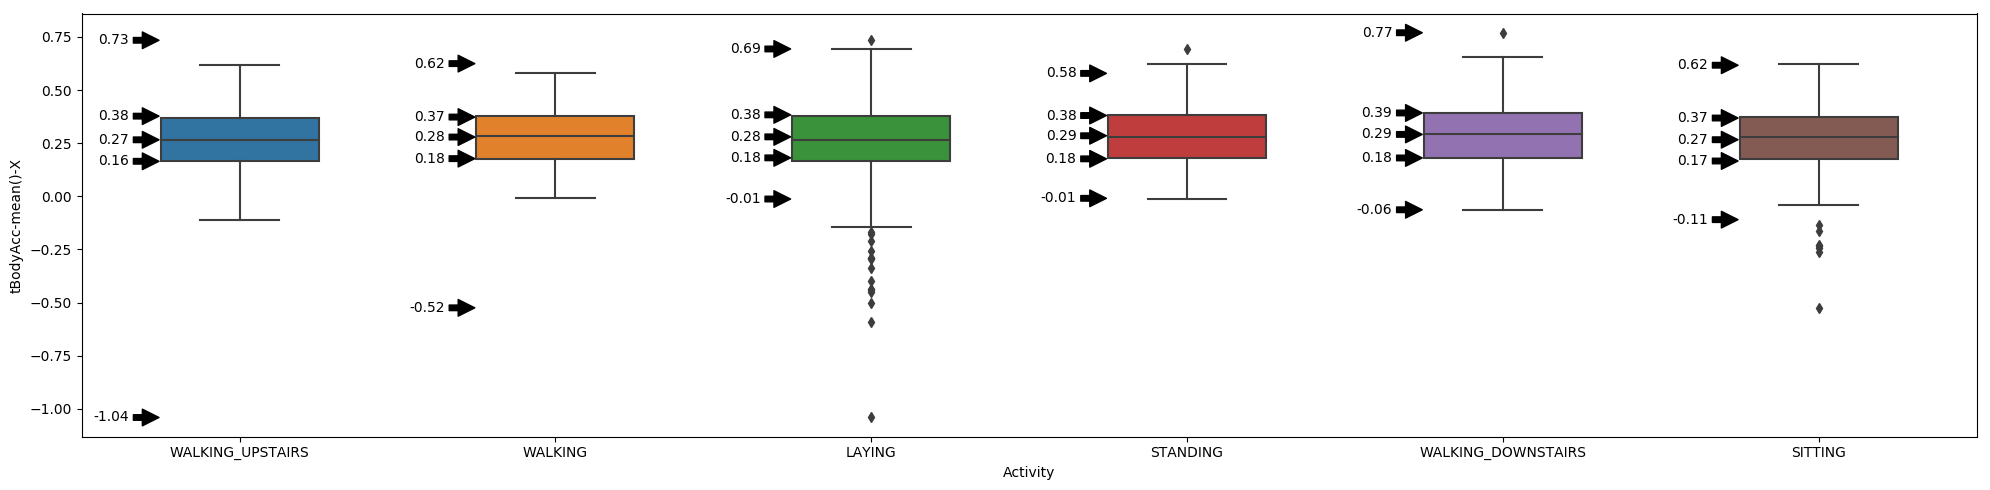

In [5]:
# 画箱线图
train_csv_path = f'{parent_path}/train.csv'
test_csv_path = f'{parent_path}/test.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# print(train_df.shape)
# print(train_df.columns)
# 统计Activity数量并画图
# train_df['Activity'].value_counts().plot(kind='bar')
plt.figure(figsize=(20, 5))
box_width = 0.5
plot_x = 'Activity'
plot_y = 'tBodyAcc-mean()-X'
ax = sns.boxplot(data=train_df, y=plot_y, x=plot_x, width=box_width)
i = 0
for name, group in train_df.groupby(plot_x):
    Q0, Q1, Q2, Q3, Q4 = group[plot_y].quantile([0, 0.25, 0.5, 0.75, 1])
    for q in (Q0, Q1, Q2, Q3, Q4):
        x = i - box_width / 2
        y = q
        ax.annotate('%.2f' % q, (x, y),
                    xytext=(x - 0.1, y), textcoords='data',
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    va='center', ha='right')

    i += 1
plt.tight_layout()
plt.savefig('pltSavefig.jpg')

#### 2.5.2、去除异常值

In [6]:
# 去除异常值
train_csv_path = f'{parent_path}/train.csv'
data_dict = read_csv_as_dict(train_csv_path)
# 去除每个参数中的异常值，561个参数
for label_key in label_keys:
    inputx_list = data_dict[label_key]
    inputx_np = np.array(inputx_list)
    inputx_561 = inputx_np.reshape((-1, 561))  # 每行仅有561个参数
    inputx_trans = inputx_561.transpose(1, 0)  # 行列互换(561,-1)
    输入量 = inputx_trans.shape[1]
    # 通过箱线图whislo、whishi去除异常值
    outliers_index = []  # 所有异常值索引
    for inputx in inputx_trans:  # 对561个参数绘制箱线图

        df = pd.DataFrame(data={'x_axis': [label_key] * inputx_trans.shape[1],
                                'y_axis': inputx})
        # 获取四线值
        lo_whisker = boxplot_stats(df.y_axis)[0]['whislo']  # 最小值
        hi_whisker = boxplot_stats(df.y_axis)[0]['whishi']  # 最大值
        q1 = boxplot_stats(df.y_axis)[0]['q1']  # 1/4
        q3 = boxplot_stats(df.y_axis)[0]['q3']  # 3/4
        small_outliers_index = np.where(inputx < lo_whisker)[0].tolist()  # 较小异常值索引
        large_outliers_index = np.where(inputx > hi_whisker)[0].tolist()  # 较大异常值索引
        outliers_index += small_outliers_index
        outliers_index += large_outliers_index

    # 差集 所有的索引减去异常索引
    right_index = list(set(range(输入量)).difference(set(outliers_index)))
    right_inputx = inputx_trans[:, right_index]
    right_trans = right_inputx.transpose(1, 0)  # 行列互换(-1,561)
    # 创建等shape标签值
    label_np = np.ones((right_trans.shape[0], 1)).astype('int32') * label_dict[label_key]
    save_np = np.concatenate((label_np, right_trans), axis=1)
    print(right_trans.shape)
    # 保存
    np.save(train_csv_path[:-4] + f'_{label_key}.npy', save_np)


(360, 561)
(400, 561)
(361, 561)
(198, 561)
(265, 561)
(153, 561)


## 2.6、合并去除异常值后的npy结果

In [7]:
npy_path_list = glob.glob(f'{parent_path}/*.npy')
save_np = np.load(npy_path_list[0])
for npy_path in npy_path_list[1:]:
    npy = np.load(npy_path)
    save_np = np.concatenate((save_np, npy), axis=0)
np.save(f'{parent_path}/正常值.npy', save_np)


# 三、训练

In [11]:
# 继续训练从save_model/train中导入的模型编号
!python train.py  \
    --model_name NeuralNetworkStructure \
    --model_id 270 \
    --BATCH_SIZE 2

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/setuptools/depends.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
                    model_name│ NeuralNetworkStructure
──────────────────────────────┼──────────────────────────────────────────────────
                      model_id│ 270
──────────────────────────────┼──────────────────────────────────────────────────
          save_train_model_dir│ save_model/train
──────────────────────────────┼──────────────────────────────────────────────────
         save_train_best_model│ save_model/best
──────────────────────────────┼──────────────────────────────────────────────────
          save_infer_model_dir│ save_model/infer
──────────────────────────────┼──────────────────────────────────────────────────
                           gpu│ True
──────────────────────────────┼──────────────────────────────────────────────────
    

# 四、预测
## 4.1、将test.csv转为模型所需的npy格式

In [12]:
# 将test.csv转为npy
test_csv_path = f'{parent_path}/test.csv'
# 度csv数据
value_list = []
with open(test_csv_path, encoding='utf-8') as csf:
    read_train_csv = csv.reader(csf)
    head = next(read_train_csv)
    for row in read_train_csv:
        value_float = [float(x) for x in row]
        value_list.append(value_float)
# 保存
save_np = np.array(value_list)
np.save(test_csv_path[:-4] + '.npy', save_np)

## 4.2、预测并压缩结果文件为提交格式

In [14]:
!python predict.py \
        --model_name NeuralNetworkStructure \
        --save_train_best_model save_model/best96.6/train_60.pdparams \
        --BATCH_SIZE 2
!zip submission60.zip submission.csv
!rm -rf submission.csv

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/setuptools/depends.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
                    model_name│ NeuralNetworkStructure
──────────────────────────────┼──────────────────────────────────────────────────
                      model_id│ -1
──────────────────────────────┼──────────────────────────────────────────────────
          save_train_model_dir│ save_model/train
──────────────────────────────┼──────────────────────────────────────────────────
         save_train_best_model│ save_model/best96.6/train_60.pdparams
──────────────────────────────┼──────────────────────────────────────────────────
          save_infer_model_dir│ save_model/infer
──────────────────────────────┼──────────────────────────────────────────────────
                           gpu│ True
──────────────────────────────┼──────────────────────────────────

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 